In [1]:
import os
from ipaddress import AddressValueError, ip_address

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Model
import seaborn as sns
import sklearn.metrics as metrics

In [2]:
def is_private_ip(ip):
    # NaN 값이거나 문자열이 아닌 경우를 먼저 확인하여 처리
    if not isinstance(ip, str):
        return False
    
    try:
        return ip_address(ip).is_private
    except AddressValueError:
        return False

def preprocess_and_scale_data(train_files, test_files, data_path):
    # 수요일 데이터로만 학습
    train_df_list = []
    for file in train_files:
        df = pd.read_csv(os.path.join(data_path, file), encoding='latin1', low_memory=False)
        df.columns = df.columns.str.strip()
        train_df_list.append(df)
    train_df = pd.concat(train_df_list, ignore_index=True)

    # 다른 날의 데이터로 테스트
    test_df_list = []
    for file in test_files:
        df = pd.read_csv(os.path.join(data_path, file), encoding='latin1', low_memory=False)
        df.columns = df.columns.str.strip()
        test_df_list.append(df)
    test_df = pd.concat(test_df_list, ignore_index=True)

    def preprocess(df):
        # 시간에 대한 정보인 Timestamp 컬럼을 datetime 형식으로 변환하고, 시간과 요일 정보를 추출
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
        df['Hour'] = df['Timestamp'].dt.hour
        df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
        
        # is_private_ip 함수를 적용하여 사설 IP 여부를 1과 0으로 변환
        df['Src_IP_is_Private'] = df['Source IP'].apply(is_private_ip).astype(int)
        df['Dst_IP_is_Private'] = df['Destination IP'].apply(is_private_ip).astype(int)
        
        # 불필요한 컬럼 제거
        df = df.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Timestamp'])
        
        # 무한대 값을 NaN으로 바꾸고, NaN 및 누락 값 포함 행 제거
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        return df

    train_df = preprocess(train_df)
    test_df = preprocess(test_df)

    # 숫자형 feature만 선택
    numeric_cols = [col for col in train_df.columns if train_df[col].dtype in ['int64', 'float64']]

    # Get the list of columns to use for scaling, ensuring the 'Label' column is not included
    # And ensuring the columns exist in both dataframes
    numeric_cols = list(set(numeric_cols) & set(test_df.columns))
    
    # 정상 데이터만 사용하여 Autoencoder 학습
    train_benign_df = train_df[train_df['Label'] == 'BENIGN']
    
    # 스케일러를 학습 데이터의 정상 트래픽에만 fit
    scaler = MinMaxScaler()
    scaler.fit(train_benign_df[numeric_cols])
    
    # 학습 데이터 스케일링 (정상 데이터만)
    train_benign_scaled = scaler.transform(train_benign_df[numeric_cols])
    
    # 테스트 데이터 분리 및 스케일링
    test_benign_df = test_df[test_df['Label'] == 'BENIGN']
    test_attack_df = test_df[test_df['Label'] != 'BENIGN']
    
    test_benign_scaled = scaler.transform(test_benign_df[numeric_cols])
    test_attack_scaled = scaler.transform(test_attack_df[numeric_cols])

    return train_benign_scaled, test_benign_scaled, test_attack_scaled, scaler, numeric_cols

data_path = 'dataset/'
all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

train_files = [f for f in all_files if 'Monday' in f]
test_files = [f for f in all_files if 'Monday' not in f]

benign_train_data, benign_test_data, attack_test_data, scaler, numeric_cols = preprocess_and_scale_data(train_files, test_files, data_path)

X_train, X_val = train_test_split(benign_train_data, test_size=0.2, random_state=42)

benign_data = benign_test_data
attack_data = attack_test_data

In [3]:
input_dim = X_train.shape[1] # 전처리 후 데이터의 특성 수

# Input Layer
input_layer = Input(shape=(input_dim,))

# Encoder
encoder = Dense(128, activation='relu')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Dense(64, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

bottleneck = Dense(32, activation='relu')(encoder)

# Decoder
decoder = Dense(64, activation='relu')(bottleneck)
decoder = BatchNormalization()(decoder)

decoder = Dense(128, activation='relu')(decoder)
decoder = BatchNormalization()(decoder)

# Output Layer
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80)]              0         
                                                                 
 dense (Dense)               (None, 128)               10368     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                           

In [4]:
import time
start_time = time.time()
history = autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=4, batch_size=256)
end_time = time.time()
print(f"Training time: {end_time - start_time:.4f} seconds")


Epoch 1/4

1655/1655 [==============================] - 11s 6ms/step - loss: 0.0136 - val_loss: 5.5953e-04
Epoch 2/4
1655/1655 [==============================] - 9s 5ms/step - loss: 7.4037e-04 - val_loss: 3.2227e-04
Epoch 3/4
1655/1655 [==============================] - 8s 5ms/step - loss: 5.2961e-04 - val_loss: 2.4914e-04
Epoch 4/4
1655/1655 [==============================] - 9s 5ms/step - loss: 3.9963e-04 - val_loss: 1.9897e-04
Training time: 37.6619 seconds


In [5]:
benign_pred = autoencoder.predict(benign_test_data)
attack_pred = autoencoder.predict(attack_test_data)

17393/17393 [==============================] - 26s 2ms/step


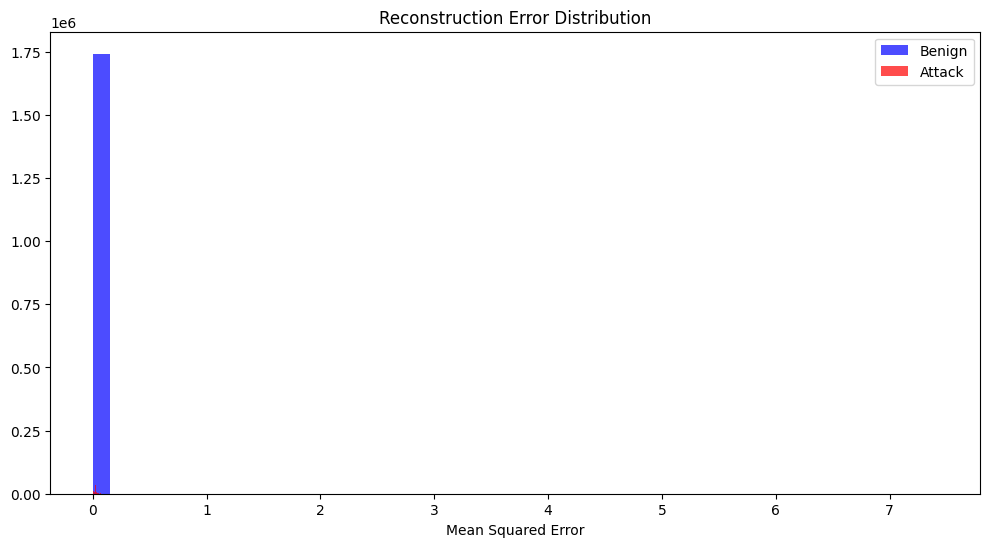

In [6]:
## Reconstruction Error
benign_mse = np.mean(np.power(benign_test_data - benign_pred, 2), axis=1)
attack_mse = np.mean(np.power(attack_test_data - attack_pred, 2), axis=1)

plt.figure(figsize=(12, 6))
plt.hist(benign_mse, bins=50, color='blue', alpha=0.7, label='Benign')
plt.hist(attack_mse, bins=50, color='red', alpha=0.7, label='Attack')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.show()

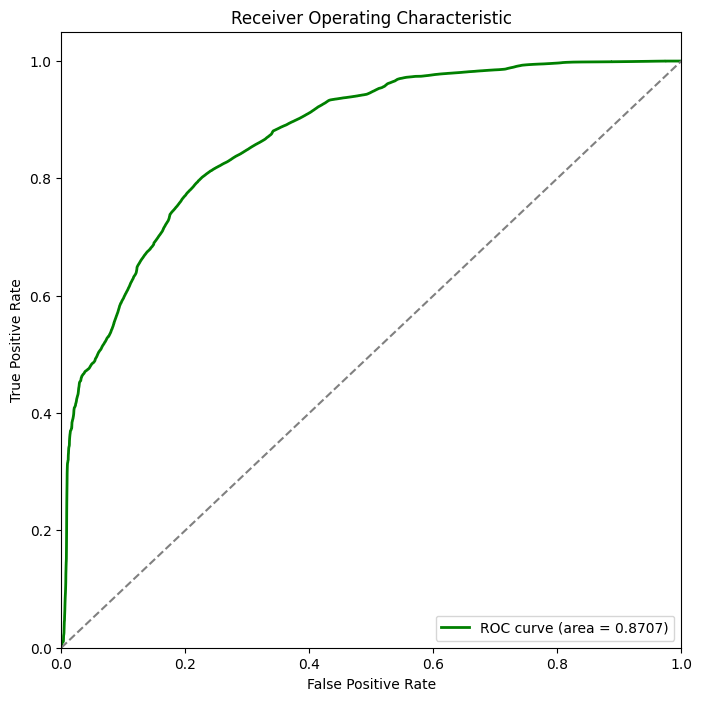

In [7]:
## ROC curve
true_labels = np.concatenate([np.zeros(len(benign_mse)), np.ones(len(attack_mse))])
pred_scores = np.concatenate([benign_mse, attack_mse])

fpr, tpr, thresholds = roc_curve(true_labels, pred_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Optimal Threshold: 0.0002
Accuracy: 0.7803
Recall: 0.8012
F1 Score: 0.6384


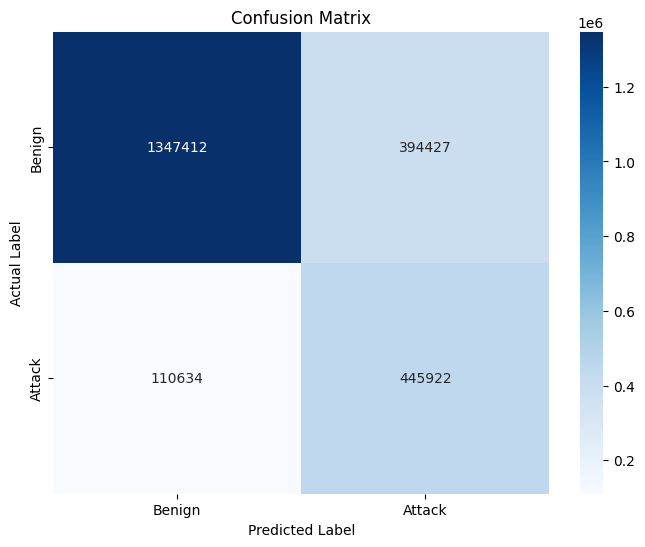

In [8]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

y_pred = (pred_scores >= optimal_threshold).astype(int)
accuracy = metrics.accuracy_score(true_labels, y_pred)
recall = metrics.recall_score(true_labels, y_pred)
f1 = metrics.f1_score(true_labels, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()